## Importing the Dataset

In [52]:
from torchvision import datasets, transforms
import numpy as np
np.random.seed(44)  
import pickle 

transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST (root='data', train=True, transform=transform, download=False)
with open('b1.pkl', 'rb') as b1:
  test_dataset = pickle.load(b1)

Checking properties of the datset

In [53]:
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))
print("Image size:", train_dataset[0][0].shape) 
print("Number of classes:", len(train_dataset.classes))
print("Class labels:", train_dataset.classes)

Training set size: 60000
Test set size: 3611
Image size: torch.Size([1, 28, 28])
Number of classes: 10
Class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Taking a look at the images

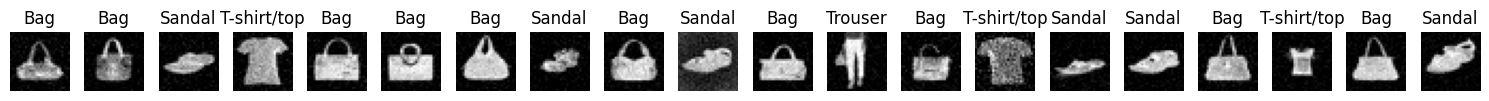

In [54]:
import matplotlib.pyplot as plt

num_samples = 20

samples = [test_dataset[i][0].numpy().squeeze() for i in range(num_samples)]
labels = [test_dataset[i][1] for i in range(num_samples)]

plt.figure(figsize=(15, 1))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(samples[i], cmap="gray")
    plt.title(f"{train_dataset.classes[labels[i]]}") 
    plt.axis("off")

plt.tight_layout()
plt.show()

Processing the dataset

In [55]:
from torch.utils.data import DataLoader, random_split
import torch 

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(68))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Defining a base class for Neural layers

In [56]:
class NeuralLayer:
    def __init__(self):
        self.training = True
    
    def train(self):
        self.training = True

    def eval(self):
        self.training = False

Implementation of dense layer

In [57]:
def normal_xavier_init (nY, nX):
    std = (2 / (nX+nY))**0.5
    W = np.random.randn(nY, nX) * std
    return W

class DenseLayer (NeuralLayer):
    pass
    def __init__(self, nX, nY, Adam=True, beta1=0.9, beta2=0.999, epsilon=1e-6):
        super().__init__()
        self.W = normal_xavier_init (nY, nX)
        self.B = np.zeros(nY)

        self.Adam = Adam
        if self.Adam:
            self.beta1 = beta1
            self.beta2 = beta2
            self.epsilon = epsilon
            self.t = 0

            self.m_w = np.ones_like(self.W) * 0.4
            self.m_b = np.zeros_like(self.B)

            self.v_w = np.ones_like(self.W) * 0.16
            self.v_b = np.zeros_like(self.B)

    def forward (self, X_in):
        self.X = X_in
        Y = np.matmul (self.X, np.transpose(self.W)) + self.B
        if np.isnan(Y).any(): 
            print("NaN detected in DenseLayer forward pass")
        return Y
    
    def backward (self, G_y, alpha):
        G_x = np.matmul (G_y, self.W)
        G_w = np.matmul (np.transpose(G_y), self.X)
        G_b = np.sum (G_y, axis=0)

        if self.Adam:   
            self.t = self.t + 1
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * G_w
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * G_b
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * G_w**2
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * G_b**2

            m_hat_w = self.m_w / (1 - np.transpose(self.beta1))
            m_hat_b = self.m_b / (1 - np.transpose(self.beta1))
            v_hat_w = self.v_w / (1 - np.transpose(self.beta2))
            v_hat_b = self.v_b / (1 - np.transpose(self.beta2))

            self.W = self.W - alpha * G_w
            self.B = self.B - alpha * G_b

        else:
            self.W = self.W - alpha * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            self.B = self.B - alpha * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

        if np.isnan(self.W).any() or np.isnan(self.B).any(): 
            print("NaN detected in DenseLayer weights/biases after update")
        
        return G_x
   


Implementation of ReLU Activation function

In [58]:
class ReLU (NeuralLayer):
    pass
    def __init__(self):
        super().__init__()

    def forward (self, X_in):
        self.X = X_in
        return np.maximum (self.X, 0)
    
    def backward (self, G_y, alpha):
        G_x = G_y * (self.X >= 0)
        return G_x

Implementation of Softmax loss function

In [59]:
class Softmax (NeuralLayer):
    pass
    def __init__(self):
        super().__init__()

    def forward (self, X_in):
        self.X = X_in
        shiftX = np.max(self.X, axis=1, keepdims=True)
        numerators = np.exp(self.X- shiftX)
        denominator = np.sum(numerators, axis=1, keepdims=True)
        self.Y = numerators / denominator 
        return self.Y

    def backward (self, Y, alpha):
        G_x = Y
        return G_x


Implementation of Dropout Layer

In [60]:
class Dropout (NeuralLayer):
    pass
    def __init__ (self, probability=0.35):
        super().__init__()
        self.probability = probability
    def forward (self, X):
        if self.training:
            prob_arr = np.random.rand(X.shape[0], X.shape[1])
            self.mask = (prob_arr >= self.probability)
            X_sel_scaled = X * self.mask / (1 - self.probability)
            return X_sel_scaled
        return X 
    
    def backward (self, G_y, alpha):
        G_x = G_y * self.mask / (1 - self.probability)
        return G_x
        

Implementation of Batch Normalisation

In [61]:
class BatchNorm (NeuralLayer):
    pass
    def __init__ (self, N, epsilon=1e-5):
        super().__init__()
        self.N = N
        self.gamma = np.ones(N)*0.5
        self.beta = np.zeros(N)
        self.epsilon = epsilon

    def forward (self, X_in):
        self.X = X_in
        self.mu = np.mean(self.X, axis=0)
        self.var = np.var(self.X, axis=0)
        self.Xhat = (self.X - self.mu) * (self.var + self.epsilon)**(-0.5)
        self.Y = self.gamma * self.Xhat + self.beta
        return self.Y
    
    def backward (self, G_y, alpha):
        G_gamma = np.sum (G_y * self.Xhat, axis=0)
        G_beta = np.sum (G_y, axis=0)
    
        G_Xhat = G_y * self.gamma
        G_x = (self.N * G_Xhat - np.sum(G_Xhat, axis=0) - self.Xhat * np.sum(G_Xhat * self.Xhat, axis=0)) / (self.N * (self.var + self.epsilon)**0.5)
        
        self.gamma = self.gamma - alpha * G_gamma
        self.beta = self.beta - alpha * G_beta

        return G_x

Sequential layer stacking mechanism

In [62]:
class Sequential (NeuralLayer):
    pass
    def __init__ (self, *layers):
        super().__init__()
        self.layers = layers

    def train (self):
        for l in self.layers:
            l.train()

    def eval (self):
        for l in self.layers:
            l.eval()

    def forward (self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward (self, G, alpha):
        for layer in reversed(self.layers):
            G = layer.backward (G, alpha)
        return G


FNN Class-1

In [63]:
class FNN1:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

FFN Class-2

In [64]:
class FNN2:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 256),
            BatchNorm(256),
            ReLU(),
            Dropout(0.1),
            DenseLayer(256, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),            
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

FFN Class-3

In [65]:
class FNN3:
    def __init__(self):
        self.model = Sequential(
            DenseLayer(784, 512),
            BatchNorm(512),
            ReLU(),
            Dropout(0.1),
            DenseLayer(512, 256),
            BatchNorm(256),
            ReLU(),
            Dropout(0.1),            
            DenseLayer(256, 128),
            BatchNorm(128),
            ReLU(),
            Dropout(0.1),
            DenseLayer(128, 64),
            BatchNorm(64),
            ReLU(),
            Dropout(0.1),
            DenseLayer(64, 10),
            Softmax()
        )

    def train(self):
        self.model.train()

    def eval(self):
        self.model.eval()

    def forward(self, X):
        return self.model.forward(X)

    def backward(self, G_y, alpha):
        return self.model.backward(G_y, alpha)

Loss Function (Cross-Entropy Loss)

In [66]:
criterion = lambda pred, true: -np.mean(np.sum(true * np.log(pred), axis=1))  # Cross-entropy loss

Training

In [67]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle as pkl 

epochs = 10

models = [FNN1(), FNN2(), FNN3()]
alphas = [0.005, 0.004, 0.003, 0.002]

results = []

best_f1_val = 0

# for model in models:
#     for learning_rate in alphas:
#         loss_fn = criterion
#         train_losses = []
#         train_accs = []
#         train_f1s = []
#         val_losses = []
#         val_accs = []
#         val_f1s = []
#         for epoch in range(epochs):
        
#             # Training loop
#             model.train()
#             train_epoch_loss = 0
#             all_preds_train = []
#             all_labels_train = []

#             for X_batch, y_batch in train_loader:
#                 X_batch = X_batch.view(X_batch.size(0), -1).numpy() 
#                 y_batch_one_hot = np.eye(10)[y_batch.numpy()]  

#                 preds = model.forward(X_batch)
#                 loss = loss_fn(preds, y_batch_one_hot)
#                 train_epoch_loss += loss

#                 grad_output = preds - y_batch_one_hot  
#                 model.backward(grad_output, learning_rate)
                
#                 predictions = np.argmax(preds, axis=1)
#                 all_preds_train.append(predictions)
#                 all_labels_train.append(y_batch.numpy())
            
#             all_preds_train = np.concatenate(all_preds_train)
#             all_labels_train = np.concatenate(all_labels_train)

#             avg_train_loss = train_epoch_loss / len(train_loader)
#             train_acc = accuracy_score(all_labels_train, all_preds_train)
#             train_f1 = f1_score(all_labels_train, all_preds_train, average="macro")

#             # Validation loop
#             model.eval()
#             val_epoch_loss = 0
#             all_preds_val = []
#             all_labels_val = []

#             for X_batch, y_batch in val_loader:
#                 X_batch = X_batch.view(X_batch.size(0), -1).numpy()  
#                 y_batch_one_hot = np.eye(10)[y_batch.numpy()]  
#                 preds = model.forward(X_batch)
#                 loss = loss_fn(preds, y_batch_one_hot)
#                 val_epoch_loss += loss

#                 predictions = np.argmax(preds, axis=1)
#                 all_preds_val.append(predictions)
#                 all_labels_val.append(y_batch.numpy())

#             all_preds_val = np.concatenate(all_preds_val)
#             all_labels_val = np.concatenate(all_labels_val)

#             avg_val_loss = val_epoch_loss / len(val_loader)
#             val_acc = accuracy_score(all_labels_val, all_preds_val) 
#             val_f1 = f1_score(all_labels_val, all_preds_val, average="macro")

#             print(f"Epoch {epoch+1}/{epochs}")
#             print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Training Macro-F1 Score: {train_f1:.4f}")
#             print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Macro-F1 Score: {val_f1:.4f}")
            
#             val_losses.append(val_epoch_loss)
#             val_accs.append(val_acc)
#             val_f1s.append(val_f1)
#             train_losses.append(train_epoch_loss)
#             train_accs.append(train_acc)
#             train_f1s.append(train_f1)

#         if val_f1 > best_f1_val:
#             with open('model_1905084.pickle', 'wb') as file:  # 'wb' means write in binary mode
#                 pkl.dump(model, file)
                
#         results.append({
#             "model": model,
#             "learning_rate": learning_rate,
#             "train_losses": train_losses,
#             "train_accs": train_accs,
#             "train_f1s": train_f1s,
#             "val_losses": val_losses,
#             "val_accs": val_accs,
#             "val_f1s": val_f1s
#         })

#         val_conf_matrix = confusion_matrix(all_labels_val, all_preds_val)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
#         plt.title(f"Confusion Matrix - Validation Data (Model: {model}, LR: {learning_rate})")
#         plt.xlabel("Predicted Labels")
#         plt.ylabel("True Labels")
#         plt.show()

# for result in results:
#     model = result["model"]
#     lr = result["learning_rate"]

#     plt.figure(figsize=(18, 5))

#     plt.subplot(1, 3, 1)
#     plt.plot(range(1, epochs + 1), result["train_losses"], label="Train Loss")
#     plt.plot(range(1, epochs + 1), result["val_losses"], label="Val Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title(f"Loss vs. Epochs (Model: {model}, LR: {lr})")
#     plt.legend()

#     plt.subplot(1, 3, 2)
#     plt.plot(range(1, epochs + 1), result["train_accs"], label="Train Accuracy")
#     plt.plot(range(1, epochs + 1), result["val_accs"], label="Val Accuracy")
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy")
#     plt.title(f"Accuracy vs. Epochs (Model: {model}, LR: {lr})")
#     plt.legend()

#     plt.subplot(1, 3, 3)
#     plt.plot(range(1, epochs + 1), result["train_f1s"], label="Train Macro-F1")
#     plt.plot(range(1, epochs + 1), result["val_f1s"], label="Val Macro-F1")
#     plt.xlabel("Epoch")
#     plt.ylabel("F1 Score")
#     plt.title(f"Macro-F1 vs. Epochs (Model: {model}, LR: {lr})")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

Best model

Test Loss: 2.4748, Test Accuracy: 0.4592, Test Macro-F1 Score: 0.2591


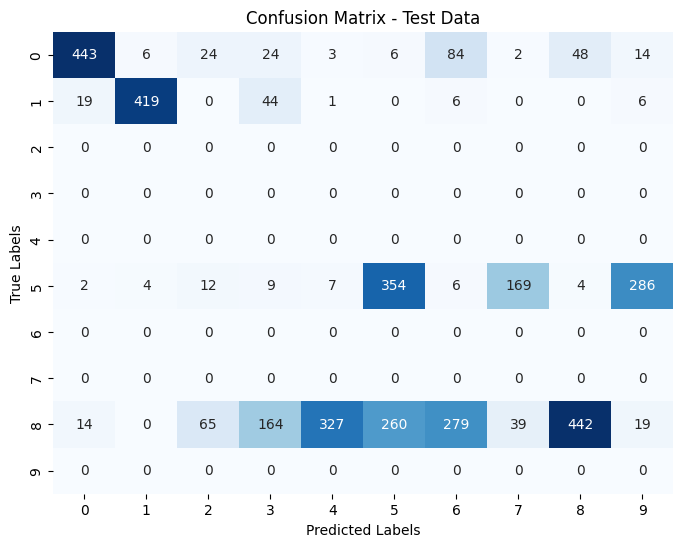

In [68]:
# learning_rate = best_alpha
epochs = 15

with open('model_1905084.pickle', 'rb') as file:  # 'rb' means read in binary mode
    model = pkl.load(file)

test_loss = 0
all_preds_test = []
all_labels_test = []

for X_batch, y_batch in test_loader:
    X_batch = X_batch.view(X_batch.size(0), -1).numpy()  
    y_batch_one_hot = np.eye(10)[y_batch.numpy()]  # One-hot encoding of labels

    preds = model.forward(X_batch)
    loss = criterion(preds, y_batch_one_hot)
    test_loss += loss

    predictions = np.argmax(preds, axis=1)
    all_preds_test.append(predictions)
    all_labels_test.append(y_batch.numpy())

all_preds_test = np.concatenate(all_preds_test)
all_labels_test = np.concatenate(all_labels_test)

avg_test_loss = test_loss / len(test_loader)
test_acc = accuracy_score(all_labels_test, all_preds_test) 
test_f1 = f1_score(all_labels_test, all_preds_test, average="macro")


print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Macro-F1 Score: {test_f1:.4f}")

test_conf_mat = confusion_matrix(all_labels_test, all_preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
 